In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from astropy.cosmology import Planck15 
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import os
%matplotlib inline

In [4]:
def inverse_transform_sampling(bins,pdf,nSamples = 10000):
    cumValue = np.zeros(bins.shape)
    cumValue[1:] = np.cumsum(pdf[1:]*np.diff(bins))
    cumValue /= cumValue.max()
    inv_cdf = interp1d(cumValue,bins)
    r = np.random.rand(nSamples)
    return inv_cdf(r)

def M1_distribution(m1,index,mmin=5,mmax=50):
    try:
        output = m1.copy()
        index_in = np.where((m1>=mmin)*(m1<=mmax))[0]
        index_out = np.where((m1<mmin)+(m1>mmax))[0]
        normalization = ((mmax)**(1+index)-mmin**(1+index))/(1+index)
        output[index_out] = 1e-30
        output[index_in] = m1[index_in]**index/normalization
    except ZeroDivisionError:
        output = m1.copy()
        index_in = np.where((m1>=mmin)*(m1<=mmax))[0]
        index_out = np.where((m1<mmin)+(m1>mmax))[0]
        normalization = np.log(mmax)-np.log(mmin)
        output[index_out] = 1e-30
        output[index_in] = m1[index_in]**index/normalization
    return output

In [5]:
N_sample = 100000
M_axis = np.linspace(5,50,10000)
q_axis = np.linspace(1e-4,1,10000)
z_axis = np.linspace(0,1,10000)
DV = Planck15.differential_comoving_volume(z_axis).value
m1 = inverse_transform_sampling(M_axis,M1_distribution(M_axis,-2,mmin=5,mmax=50),N_sample)
q =  inverse_transform_sampling(q_axis,M1_distribution(q_axis,2,mmin=0,mmax=1),N_sample)
chi1 = np.random.uniform(-1,1,N_sample)
chi2 = np.random.uniform(-1,1,N_sample)
z = inverse_transform_sampling(z_axis,DV,N_sample)
#np.savetxt('PowerLaw.txt',np.array([m1,m1*q,chi1,chi2,z]).T)

In [7]:
model = torch.jit.load('./network/AplusDesign_IMRPhenomD.network',map_location='cpu')
P_omega_data = np.genfromtxt('./data/Pw_single.dat').T
P_omega = interp1d(P_omega_data[0],P_omega_data[1],bounds_error=False,fill_value=(1,0))
z_axis = np.linspace(0,10,10000)
d_axis = Planck15.luminosity_distance(z_axis).value
dL_interp = interp1d(z_axis,d_axis)
data = torch.from_numpy(np.array([m1,m1*q,chi1,chi2,z]).T).float()

In [8]:
@torch.no_grad()
def get_SNR(M1M2s1s2,z):
    dL = dL_interp(z)
    return model(M1M2s1s2)[:,0].numpy()*100/dL

@torch.no_grad()
def get_pdet(M1M2s1s2,z,threshold=8):
    snr = get_SNR(M1M2s1s2,z)
    return P_omega(threshold/snr)

@torch.no_grad()
def get_detect(M1M2s1s2,z,threshold=8):
    total_size = M1M2s1s2.shape[0]
    snr = get_SNR(M1M2s1s2,z)
    pdet = P_omega(threshold/snr)
    detect_size = np.sum(pdet[snr>threshold])
    return M1M2s1s2[snr>threshold],detect_size/total_size
    

In [9]:
%time get_pdet(data[:,:4],data[:,-1])

CPU times: user 27.9 s, sys: 2min 56s, total: 3min 24s
Wall time: 1min 3s


array([0.62472831, 0.49147653, 0.29979356, ..., 0.44291149, 0.93309675,
       0.89508916])

In [11]:
%time detect = get_detect(data[:,:4],data[:,-1],50)

CPU times: user 27.6 s, sys: 10.7 s, total: 38.3 s
Wall time: 12.4 s


Text(0, 0.5, '$p(M_1)$')

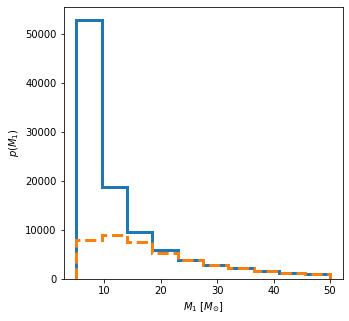

In [11]:
fig = plt.figure(figsize=(5,5))
plt.hist(data.T[0],histtype='step',lw=3)
plt.hist(detect[0].T[0],histtype='step',lw=3,ls='--')
plt.xlabel(r'$M_1\ [M_{\odot}]$')
plt.ylabel(r'$p(M_1)$')